In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import ipywidgets
import jupyterlab_widgets
from tqdm.auto import tqdm
# Ignore Warnings
import warnings
import time
warnings.filterwarnings("ignore")

# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            if fold == '1':
                labels.append('meningioma')
            elif fold == '2':
                labels.append('glioma')
            elif fold == '3':
                labels.append('pituitary tumor')

    return filepaths, labels

# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)


# Split dataframe to train, valid, and test
def create_df(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [4]:
data_dir = '/kaggle/input/brain-tumor'

try:
    # Get splitted data
    train_df, valid_df, test_df = create_df(data_dir)
    display(train_df)
except:
    print('Invalid Input')

,filepaths,labels
1427,/kaggle/input/brain-tumor/3/2015.png,pituitary tumor
517,/kaggle/input/brain-tumor/2/715.png,glioma
1377,/kaggle/input/brain-tumor/2/693.png,glioma
1407,/kaggle/input/brain-tumor/2/175.png,glioma
2720,/kaggle/input/brain-tumor/1/2436.png,meningioma
...,...,...
1525,/kaggle/input/brain-tumor/3/1698.png,pituitary tumor
2973,/kaggle/input/brain-tumor/1/3017.png,meningioma
450,/kaggle/input/brain-tumor/2/434.png,glioma
2200,/kaggle/input/brain-tumor/3/1525.png,pituitary tumor


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [10]:
class BrainTumorCNN(nn.Module):
    def __init__(self):
        super(BrainTumorCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 3)  # 3 classes: glioma, meningioma, pituitary tumor
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to a consistent size
    transforms.ToTensor(),  
    transforms.Normalize((0.,), (1.,))  
])


dataset = ImageFolder("/kaggle/input/brain-tumor", transform=transform)
display(dataset)




Dataset ImageFolder
    Number of datapoints: 3064
    Root location: /kaggle/input/brain-tumor
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.0,), std=(1.0,))
           )

In [12]:
def model_summary(model, input_size):
    def get_num_params(layer):
        return sum(p.numel() for p in layer.parameters() if p.requires_grad)
    
    print(f"{'Layer Name':<30} {'Output Shape':<30} {'Param #':<15}")
    print("="*75)
    
    # Create a dummy input to track the output sizes
    dummy_input = torch.randn(1, *input_size).to(next(model.parameters()).device)
    
    def forward_hook(layer, input, output):
        layer_name = layer.__class__.__name__
        output_shape = list(output.size())
        param_count = get_num_params(layer)
        
        print(f"{layer_name:<30} {str(output_shape):<30} {param_count:<15}")

    hooks = []
    for layer in model.children():
        if isinstance(layer, nn.Sequential):
            for sub_layer in layer.children():
                hooks.append(sub_layer.register_forward_hook(forward_hook))
        else:
            hooks.append(layer.register_forward_hook(forward_hook))
    
    # Forward pass to generate the summary
    model(dummy_input)
    
    # Remove hooks after use
    for hook in hooks:
        hook.remove()

# Example usage
model = BrainTumorCNN().to(device)
model_summary(model, (3, 64, 64))


Layer Name                     Output Shape                   Param #        
Conv2d                         [1, 16, 64, 64]                448            
ReLU                           [1, 16, 64, 64]                0              
MaxPool2d                      [1, 16, 32, 32]                0              
Conv2d                         [1, 32, 32, 32]                4640           
ReLU                           [1, 32, 32, 32]                0              
MaxPool2d                      [1, 32, 16, 16]                0              
Conv2d                         [1, 64, 16, 16]                18496          
ReLU                           [1, 64, 16, 16]                0              
MaxPool2d                      [1, 64, 8, 8]                  0              
Linear                         [1, 128]                       524416         
ReLU                           [1, 128]                       0              
Linear                         [1, 3]                         38

In [8]:
# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Create an instance of the CNN model
model = BrainTumorCNN().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    correct = 0.0
    # Training
    model.train()
    loop = tqdm(enumerate(train_loader), total = len(train_loader), bar_format=f"Epoch [{epoch+1}".ljust(9) + f"/ {num_epochs}]\t" + '{bar}{r_bar}')
    for batch_idx, (images, labels) in loop:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Progress bar version kontrimnon
        loop.set_postfix(loss = loss.item())
        # Update train_loss
        train_loss += loss.item() * images.size(0)

    # Validation
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    
    train_loss = train_loss / len(train_dataset)
    val_loss = val_loss / len(val_dataset)
    accuracy = correct / len(val_dataset)
    # Print the loss and the accuracy of kontrimnon
    print(f"Train Loss (final): {train_loss:.4f} | Val Loss: {val_loss:.4f} | Accuracy: {accuracy * 100:.4f}%")

Epoch [1 / 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.8221 | Val Loss: 0.6472 | Accuracy: 70.3100%


Epoch [2 / 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.5761 | Val Loss: 0.5198 | Accuracy: 74.5514%


Epoch [3 / 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.4624 | Val Loss: 0.4220 | Accuracy: 81.0767%


Epoch [4 / 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.3992 | Val Loss: 0.4039 | Accuracy: 84.9918%


Epoch [5 / 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.3597 | Val Loss: 0.3509 | Accuracy: 86.4600%


Epoch [6 / 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.3034 | Val Loss: 0.3129 | Accuracy: 87.7651%


Epoch [7 / 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.2873 | Val Loss: 0.2727 | Accuracy: 91.0277%


Epoch [8 / 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.2295 | Val Loss: 0.2545 | Accuracy: 90.3752%


Epoch [9 / 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.1734 | Val Loss: 0.2381 | Accuracy: 91.5171%


Epoch [10/ 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.1490 | Val Loss: 0.2406 | Accuracy: 91.0277%


Epoch [11/ 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.1339 | Val Loss: 0.2080 | Accuracy: 93.3116%


Epoch [12/ 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.1045 | Val Loss: 0.2514 | Accuracy: 92.9853%


Epoch [13/ 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.0758 | Val Loss: 0.2366 | Accuracy: 93.1485%


Epoch [14/ 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.0643 | Val Loss: 0.2291 | Accuracy: 92.8222%


Epoch [15/ 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.0429 | Val Loss: 0.2378 | Accuracy: 93.9641%


Epoch [16/ 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.0346 | Val Loss: 0.2446 | Accuracy: 93.4747%


Epoch [17/ 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.0218 | Val Loss: 0.2618 | Accuracy: 94.6166%


Epoch [18/ 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.0177 | Val Loss: 0.3525 | Accuracy: 93.4747%


Epoch [19/ 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.0257 | Val Loss: 0.3198 | Accuracy: 94.1272%


Epoch [20/ 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.0251 | Val Loss: 0.3591 | Accuracy: 93.1485%


Epoch [21/ 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.0391 | Val Loss: 0.2625 | Accuracy: 93.8010%


Epoch [22/ 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.0291 | Val Loss: 0.3529 | Accuracy: 93.6378%


Epoch [23/ 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.0303 | Val Loss: 0.2714 | Accuracy: 92.9853%


Epoch [24/ 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.0244 | Val Loss: 0.3151 | Accuracy: 93.3116%


Epoch [25/ 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.0094 | Val Loss: 0.2936 | Accuracy: 94.4535%


Epoch [26/ 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.0023 | Val Loss: 0.2883 | Accuracy: 94.2904%


Epoch [27/ 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.0014 | Val Loss: 0.3291 | Accuracy: 94.1272%


Epoch [28/ 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.0009 | Val Loss: 0.3183 | Accuracy: 94.4535%


Epoch [29/ 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.0005 | Val Loss: 0.3176 | Accuracy: 94.7798%


Epoch [30/ 30]	          | 0/77 [00:00<?, ?it/s]

Train Loss (final): 0.0004 | Val Loss: 0.3348 | Accuracy: 94.6166%


In [13]:
print(f">> Accuracy: {accuracy*100}%")

>> Accuracy: 94.61663947797716%


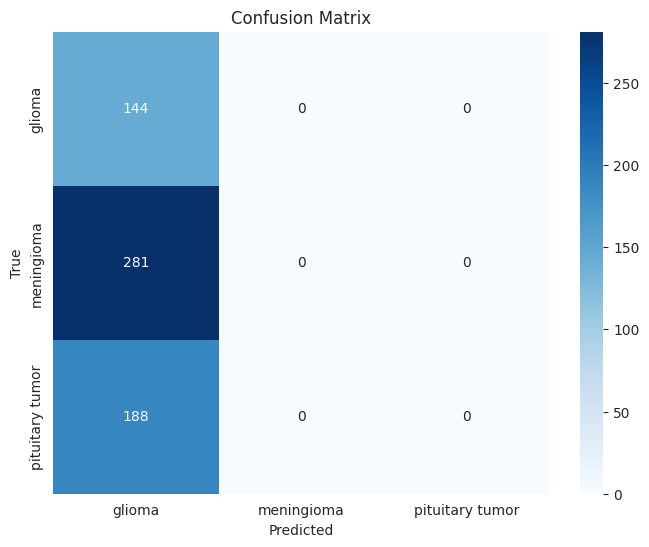

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Evaluation loop
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Define class labels
class_labels = ['glioma', 'meningioma', 'pituitary tumor']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()